## Feature Development Extraction: Neurophysiology [dyskinesia project]




<b> Content </b>


<b> Aperiodic estimates </b>
Relevant literature:
- Periodic and a-periodic components relevance and interaction, different reasons (per + a-per) for signal changes observed within a specific bandwidth. Aperiodic component (complicated) vs exponent (1/f) (Donoghue, ..., Shestyuk & Voytek, Nature Neurosc 2020 : https://www.nature.com/articles/s41593-020-00744-x)
- cycle-by-cycle features: bycycle toolbox (Cole & Voytek, J of Neurophys 2019, https://journals.physiology.org/doi/full/10.1152/jn.00273.2019)
- aperiodic component, PD severity, and cortico-subcortico-activity, Bush & Zou, Richardson, bioRxiv 2023 https://www.biorxiv.org/content/10.1101/2023.02.08.527719v1?rss=1

<b> Periodic component analysis: </b> 
- Try Wavelet Dceomposition vs Welch (tapered) Spectral Decomposition





### 0. Loading packages and functions, defining paths



In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import csv
from dataclasses import dataclass, field, fields
from collections import namedtuple
from typing import Any
from itertools import compress
from pathlib import Path
import pandas as pd
import numpy as np
import sklearn as sk
from scipy.stats import pearsonr, mannwhitneyu

import matplotlib.pyplot as plt

from scipy import signal, stats
from array import array
import datetime as dt
# #mne
# import mne_bids
import mne


In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
# print('mne_bids', mne_bids.__version__)
# print('mne', mne.__version__)
# print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)
## FEB 2022:
# Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
# [Clang 10.0.0 ]
# pandas 1.3.4
# numpy 1.20.3
# mne_bids 0.9
# mne 0.24.1
# sci-py 1.7.1
# sci-kit learn 1.0.1

Python sys 3.9.0 (default, Nov 15 2020, 08:30:55) [MSC v.1916 64 bit (AMD64)]
pandas 1.4.4
numpy 1.23.3
sci-kit learn 1.1.3


In [3]:
def get_project_path_in_notebook(
    subfolder: str = '',
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    return path

In [4]:
# define local storage directories
projectpath = get_project_path_in_notebook()
codepath = os.path.join(projectpath, 'code')
figpath = os.path.join(projectpath, 'figures')
datapath = os.path.join(projectpath, 'data')

In [5]:
os.chdir(codepath)
# own utility functions
import utils.utils_fileManagement as utilsFiles
import utils.utils_windowing as utilsWindows
from utils.utils_fileManagement import (get_project_path,
                                        load_class_pickle,
                                        save_class_pickle,
                                        mergedData,
                                        correct_acc_class)
# own data preprocessing functions
import lfpecog_preproc.preproc_data_management as dataMng
import lfpecog_preproc.preproc_filters as fltrs
# own data exploration functions
import lfpecog_features.feats_read_proc_data as read_data
import lfpecog_plotting.expl_plotting as expl_plot
import lfpecog_features.feats_spectral_baseline as specBase
import lfpecog_features.feats_spectral_features as spectral
import lfpecog_features.feats_spectral_helpers as specHelp


import lfpecog_preproc.preproc_import_scores_annotations as importClin
import lfpecog_analysis.import_ephys_results as importResults
import lfpecog_analysis.get_acc_derivs as accDerivs


from lfpecog_plotting.plotHelpers import remove_duplicate_legend

In [10]:
def get_colors(scheme='access_colors_PaulTol'):
    """
    if scheme is 'access_colors_PaulTol' Paul Tol's
        colorscheme for accessible colors is returned,
    if scheme is 'contrast_duo', two contrasting colors
        are returned
    """
    cmap_json = os.path.join(codepath, 'lfpecog_plotting',
                             'color_schemes.json')

    with open(cmap_json, 'r') as json_data:
        schemes = json.load(json_data)

    cmap = schemes[scheme]

    return cmap

In [17]:
import traces
import datetime as dt

In [102]:
importlib.reload(importClin)
# CHECK CLINICAL RATINGS
subs_incl = ['008', '009', '010', '012',
             '013', '014', '016']

clrs = list(get_colors().values())
styles = ['solid', 'dotted']
fig, axes = plt.subplots(1,1, figsize=(12, 6))

for i_sub, sub in enumerate(subs_incl):
    reg_t, reg_scores = {}, {}
    for i_r, rater in enumerate(['Patricia', 'Jeroen']):
        t, scores = importClin.get_cdrs_specific(sub=sub, rater=rater)
        axes.plot(t, scores,  # [0]
                color=clrs[i_sub], ls=styles[i_r], lw=3, label=f'{sub} ({rater})')

        # regularize scores
        reg_t[i_r], reg_scores[i_r] = importClin.get_cdrs_specific(
            sub=sub, rater=rater, regularize=True,)
        # axes[1].plot(reg_t[i_r], reg_scores[i_r],
        #         color=clrs[i_sub], ls=styles[i_r], lw=3, )
    
    # calculate correlations
    # only take minutes present in both scores
    t_start = max([reg_t[i_r][0] for i_r in [0, 1]])
    t_stop = min([reg_t[i_r][-1] for i_r in [0, 1]])
    sel0 = [time >= t_start and time <= t_stop for time in reg_t[0]]
    sel1 = [time >= t_start and time <= t_stop for time in reg_t[1]]
    
    print(sub, pearsonr(reg_scores[0][sel0], reg_scores[1][sel1]))

# axes[0].set_title('Inserted scores per timepoint', size=14)
# axes[1].set_title('Interpolated scores (per 1 minute)', size=14)
handles, labels = axes.get_legend_handles_labels()
plt.legend(handles, labels, ncol=5, bbox_to_anchor=(.5, -.25),
               loc='upper center', fontsize=14,)
# for ax in axes:
axes.set_ylabel('CDRS score', fontsize=14)
axes.set_xlabel('Time (minutes vs LDOPA-intake)', fontsize=14)
axes.tick_params(axis='both', labelsize=14, size=14)

plt.tight_layout()
# figname = 'CDRS_scores_2rater_interpolation'
# plt.savefig(os.path.join(figpath, 'clinical_scores', figname), dpi=150,
#             facecolor='w',)
# figname = 'CDRS_scores_2raters'
# plt.savefig(os.path.join(figpath, 'clinical_scores', figname), dpi=150,
#             facecolor='w',)
plt.close()




008 PearsonRResult(statistic=0.6221491063029219, pvalue=0.000314146701594982)
009 PearsonRResult(statistic=0.760446396727853, pvalue=5.379647532914257e-14)
010 PearsonRResult(statistic=0.6385461437810538, pvalue=3.362919252164951e-12)
012 PearsonRResult(statistic=0.7235559463509389, pvalue=6.74411270781571e-12)
013 PearsonRResult(statistic=0.6154322152783165, pvalue=4.150170910173506e-06)
014 PearsonRResult(statistic=0.6390822837532527, pvalue=1.3586109858800794e-10)
016 PearsonRResult(statistic=0.4368720593996336, pvalue=4.069492111886793e-05)


### 1. Load Merged Sub-Data

#### load none ephys pickle

In [ ]:
subs_to_plot = [
    '008', '009', '010', '012', 
    '013', '014', '016']

data_version = 'v3.1'
mins_recording = []

for sub in subs_to_plot:
    # load Acc-detected movement labels
    acc = load_class_pickle(os.path.join(
        get_project_path('data'),
        'merged_sub_data', data_version,
        f'{sub}_mergedDataClass_{data_version}_noEphys.P'
    ))
    acc = correct_acc_class(acc)

    mins_recording.append(acc.data.shape[0] / acc.fs / 60)

#### load ephys pickle

WINDOWED DATA

In [103]:
subs_to_plot = [
    # '008', '009', '010', '012', 
    # '013', '014',
    '012',
]
task = 'rest'
data_version = 'v3.0'
mins_recording = []

for sub in subs_to_plot:
    # load Acc-detected movement labels
    data = load_class_pickle(os.path.join(
        get_project_path('data'), 'windowed_data_classes_60s',
        data_version, f'sub-{sub}', task,
        f'{sub}_mneEpochs_{task}_{data_version}_win60s_overlap0.5.P'
    ))
    # acc = correct_acc_class(acc)


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\habetsj\\Research\\projects\\dyskinesia_neurophys\\data\\windowed_data_classes_60s\\v3.0\\sub-012\\rest\\012_mneEpochs_rest_v3.0_win60s_overlap0.5.P'

In [ ]:
data.list_mne_objects[0].times.shape

data.list_mne_objects[0].ch_names

data.list_mne_objects[0].get_data().shape

MERGED DATA per DATATYPE (source)


In [104]:
subs_incl = [
    '013', 
    # '009', '010', '012', 
    # '013', '014',
    # '012',
]
# task = 'rest'
data_version = 'v3.0'

for sub in subs_incl:
    # load merged data class
    data = load_class_pickle(os.path.join(
        get_project_path('data'), 'merged_sub_data',
        data_version,
        f'{sub}_mergedDataClass_{data_version}.P'
    ))

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\habetsj\\Research\\projects\\dyskinesia_neurophys\\data\\merged_sub_data\\v3.0\\013_mergedDataClass_v3.0.P'

In [ ]:
sub = '012'
dat = {}
dType = 'lfp_left'
dat[dType] = load_class_pickle(os.path.join(
        get_project_path('data'), 'merged_sub_data',
        data_version, f'sub-{sub}',
        f'{sub}_mergedData_{data_version}_{dType}.P'
    ))

Load windows

In [141]:
ephys_sources = ['lfp_left', ]  #'lfp_right', 'ecog_left', 'ecog_right']
use_stored_windows = True

sub = '014'
json_path = os.path.join(utilsFiles.get_onedrive_path('data'),
                     'featureExtraction_jsons',
                     'ftExtr_spectral_v1.json')
with open(json_path, 'r') as json_data:
    SETTINGS = json.load(json_data)

windows_path = os.path.join(utilsFiles.get_project_path('data'),
                    'windowed_data_classes_'
                    f'{SETTINGS["WIN_LEN_sec"]}s_'
                    f'{SETTINGS["WIN_OVERLAP_part"]}overlap',
                    SETTINGS['DATA_VERSION'],
                    f'sub-{sub}')

In [106]:
for dType in ephys_sources:
    print(f'\tstart {dType}')
    # define path for windows of dType
    dType_fname = (f'sub-{sub}_windows_'
                    f'{SETTINGS["WIN_LEN_sec"]}s_'
                    f'{SETTINGS["DATA_VERSION"]}_{dType}.P')
    dType_win_path = os.path.join(windows_path, dType_fname)
    
    # check if windows are already available
    if np.logical_and(use_stored_windows,
                        os.path.exists(dType_win_path)):
        print(f'load data from {windows_path}....')
        windows = utilsFiles.load_class_pickle(dType_win_path)
        print(f'\tWINDOWS LOADED from {dType_fname} in {windows_path}')

	start lfp_left
load data from c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.0overlap\v3.0\sub-014....
	WINDOWS LOADED from sub-014_windows_10s_v3.0_lfp_left.P in c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.0overlap\v3.0\sub-014


In [107]:
# filter out none-ephys signals
sel_chs = [c.startswith('LFP') or c.startswith('ECOG')
            for c in windows.keys]
print(f'GOT WINDOWS {dType}, shape: {windows.data.shape}, '
        f'colnames: {windows.keys}')
setattr(windows, 'data', windows.data[:, :, sel_chs])
setattr(windows, 'keys', list(compress(windows.keys, sel_chs)))
print(f'\tWINDOWS {dType} ONLY EPHYS, shape: {windows.data.shape}, '
        f'colnames: {windows.keys}')

GOT WINDOWS lfp_left, shape: (336, 20480, 19), colnames: ['dopa_time', 'LFP_L_02_03', 'LFP_L_03_04', 'LFP_L_04_02', 'LFP_L_02_05', 'LFP_L_03_06', 'LFP_L_04_07', 'LFP_L_05_06', 'LFP_L_06_07', 'LFP_L_07_05', 'LFP_L_05_08', 'LFP_L_06_08', 'LFP_L_07_08', 'task', 'left_tap', 'right_tap', 'left_move', 'right_move', 'no_move']
	WINDOWS lfp_left ONLY EPHYS, shape: (336, 20480, 12), colnames: ['LFP_L_02_03', 'LFP_L_03_04', 'LFP_L_04_02', 'LFP_L_02_05', 'LFP_L_03_06', 'LFP_L_04_07', 'LFP_L_05_06', 'LFP_L_06_07', 'LFP_L_07_05', 'LFP_L_05_08', 'LFP_L_06_08', 'LFP_L_07_08']


In [149]:
importlib.reload(spectral)
importlib.reload(specHelp)

<module 'lfpecog_features.feats_spectral_helpers' from 'c:\\Users\\habetsj\\Research\\projects\\dyskinesia_neurophys\\code\\lfpecog_features\\feats_spectral_helpers.py'>

In [170]:
# loop over windows
for i_w, win_dat in enumerate(windows.data[:5]):
    win_dat = win_dat.astype(np.float64)    
    # select only rows without missing
    nan_rows = np.array([pd.isna(win_dat[:, i]).any()
                for i in range(win_dat.shape[-1])])
    win_dat = win_dat[:, ~nan_rows]

    if dType.upper().startswith('LFP'): s = 'STN'
    elif dType.upper().startswith('ECOG'): s = 'ECOG'
    ap_offset, ap_exp, ap_fitr2 = spectral.get_aperiodic(
        data=win_dat.T, fs=windows.fs, method='fooof',
        method_params=SETTINGS['FOOOF_SETTINGS'][s],
    )
    ### TODO: FIX NOTCH CORRECTION

(12, 1025)


IndexError: index 44 is out of bounds for axis 0 with size 12

In [172]:
import lfpecog_features.feats_ssd as ssd

In [231]:
importlib.reload(ssd)
# loop over windows

for i_w, win_dat in enumerate(windows.data[:5]):
    win_dat = win_dat.astype(np.float64)    
    # select only rows without missing
    nan_rows = np.array([pd.isna(win_dat[:, i]).any()
                for i in range(win_dat.shape[-1])])
    win_dat = win_dat[:, ~nan_rows]
    win_chnames = list(compress(windows.keys, ~nan_rows))
    win_time = windows.win_starttimes[i_w]
    
    ssds = ssd.SSD_bands(
        data=win_dat.T, s_rate=windows.fs,
        freq_bands_incl=SETTINGS['SPECTRAL_BANDS']
    )

    
    # loop over defined frequency bands
    for bw in SETTINGS['SPECTRAL_BANDS']:
        f_range = SETTINGS['SPECTRAL_BANDS'][bw]
        # check whether to perform SSD
        # (ssd_filt_data,
        #     ssd_pattern,
        #     ssd_eigvals
        # ) = ssd.get_SSD_component(
        #     data_2d=win_dat.T,
        #     fband_interest=f_range,
        #     s_rate=windows.fs,
        #     use_freqBand_filtered=True,
        #     return_comp_n=0,
        # )

    #     f, psd = signal.welch(ssd_filt_data, axis=-1,
    #                     nperseg=windows.fs, fs=windows.fs)
    #     plt.plot(f, psd, label=bw)

            

    # plt.xlim(0, 100)
    # plt.title(f'WINDOW # {i_w} - {dType.upper()}')
    # plt.legend()
    # plt.show()

c:\Users\habetsj\Research\projects\dyskinesia_neurophys\code\meet\meet\_cSPoC.py:52: LinAlgWarning: Ill-conditioned matrix (rcond=7.79426e-17): result may not be accurate.
  pat = _linalg.solve(_np.atleast_2d(a), _np.atleast_2d(b.T))
c:\Users\habetsj\Research\projects\dyskinesia_neurophys\code\meet\meet\_cSPoC.py:52: LinAlgWarning: Ill-conditioned matrix (rcond=8.43869e-17): result may not be accurate.
  pat = _linalg.solve(_np.atleast_2d(a), _np.atleast_2d(b.T))


Phase features to add:
- local PAC from De Hempt (ECoG) (beta-phase, gamma-ampl)
    - check calculation via entropy of amplitudes per bin
    - or MI-inde
- connectivity phase differences from Swann et al (phase-coherence) (angle STN versus angle ECoG, compare with imaginary-coherence)

In [381]:
import lfpecog_plotting.phase_plotting as phaseplot

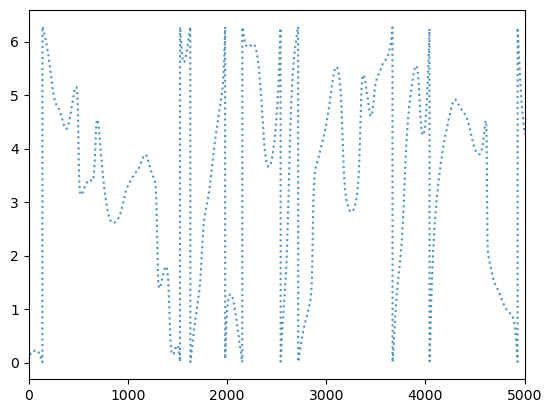

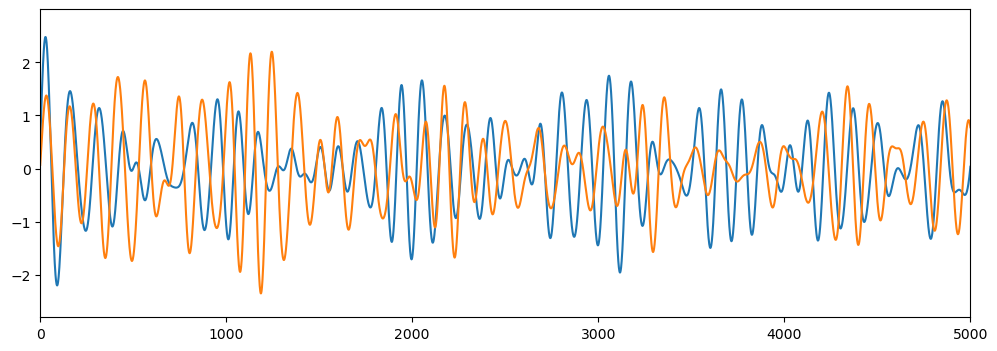

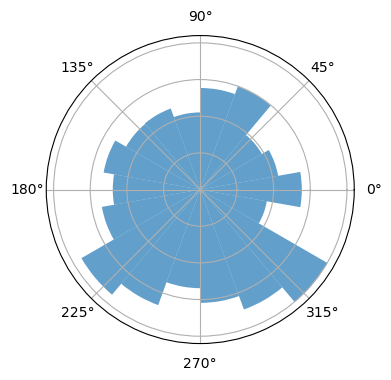

In [382]:
importlib.reload(phaseplot)

### phase difference
# plt.figure(figsize=(12, 4))
# get both signals
sig1 = ssds.lo_beta.copy()
sig2 = ssd0.lo_beta.copy()
# convert to analytic signal
a1 = signal.hilbert(x=sig1,)
a2 = signal.hilbert(x=sig2,)
# get phase from analytical signal, convert from pi to degree
rad1 = np.angle(a1)
deg1 = np.rad2deg(rad1)
rad2 = np.angle(a2)
deg2 = np.rad2deg(rad2)
# get difference, convert all to positive degrees (-90 -> +270)
rad_diff = rad1 - rad2
deg_diff = deg1 - deg2
mask_deg = deg_diff < 0  # bool-array, 0 for values >= 0
mask_rad = rad_diff < 0
corr_rad = np.array([2 * np.pi] * len(rad_diff)) * mask_rad  # corr array is set 0 for pos diff-values
rad_diff += corr_rad
corr_deg = np.array([360] * len(deg_diff)) * mask_deg  # corr array is set 0 for pos diff-values
deg_diff += corr_deg
plt.plot(rad_diff, label='corr', alpha=.8, ls='dotted')
plt.xlim(0, 5000)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(sig1)
plt.plot(sig2)
plt.xlim(0, 5000)
plt.show()

phaseplot.plot_rose_axis(radians=rad_diff)

(20480,)


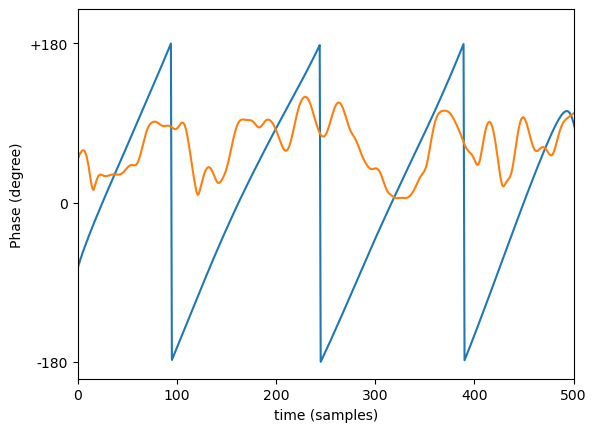

In [213]:
sig_phase = ssds.lo_beta.copy()
sig_ampl = ssds.broad_gamma.copy()
sig = ssds.lo_beta.copy()
print(sig.shape)
a_phase = signal.hilbert(x=sig_phase,)
a_ampl = signal.hilbert(x=sig_ampl,)
phase = np.angle(a_phase)
# phase_deg = phase * (180 / np.pi)
ampl = abs(a_ampl)
plt.plot(phase)
plt.plot(ampl)
plt.xlim(0, 500)
plt.yticks([-np.pi, 0, np.pi],
           labels=['-180', '0', '+180'],)
plt.ylabel('Phase (degree)')
plt.xlabel('time (samples)')
plt.show()



In [384]:
import tensorpac


In [385]:
from tensorpac import Pac


In [401]:
# create settings for PAC calculation
pac_settings = {'phase': {}, 'ampl': {}}
pac_settings['phase']['f_range'] = [12, 20]
pac_settings['phase']['bin_w'] = 2
pac_settings['ampl']['f_range'] = [60, 90]
pac_settings['ampl']['bin_w'] = 4
pac_bins = {}
for k in ['phase', 'ampl']:
    pac_bins[k] = [[start, start + pac_settings[k]['bin_w']]
                for start in np.arange(pac_settings[k]['f_range'][0],
                                        pac_settings[k]['f_range'][1],
                                        pac_settings[k]['bin_w'])]



In [412]:
pha_arr = np.array([ssds.lo_beta, ssds.lo_beta, ssds.lo_beta])
amp_arr = np.array([ssds.broad_gamma, ssds.broad_gamma, ssds.broad_gamma])



In [402]:

pac_model = Pac(idpac=(2, 0, 0), dcomplex='hilbert',
                f_pha=pac_bins['phase'],
                f_amp=pac_bins['ampl'],)
# first digit is method; 2=MI, 2nd digit is norm: 0=no norm


Phase Amplitude Coupling object defined


In [413]:
xpac = pac_model.filterfit(sf=ssds.s_rate,
                           x_pha=pha_arr,
                           x_amp=amp_arr,)

    extract phases (n_pha=4) and amplitudes (n_amps=8)
    true PAC estimation using Modulation Index (MI, Tort et al. 2010)


In [418]:
pac_bins

{'phase': [[12, 14], [14, 16], [16, 18], [18, 20]],
 'ampl': [[60, 64],
  [64, 68],
  [68, 72],
  [72, 76],
  [76, 80],
  [80, 84],
  [84, 88],
  [88, 92]]}

In [424]:
### TODO:
# create import function for SSD_windowedBands
#   use path creation from ft-function

# calculate local-PACs per dtype (2d-pac-array per window)
# resulting in 3d array [n-windows, n-ampl-bins, n-phase-bins]

# import SSD Bands for two datatypes
#   create sq- and i-coherence between different location
#   create phase differences between locations

(2, 4, 4)

In [425]:
plt.subplot(1, 1, 1)
pac_model.comodulogram(xpac.mean(-1), title="Phase of the first dataset and "
               "amplitude of the second", cmap='Reds')

plt.close()

In [218]:
phase_deg = phase * (180 / np.pi)

phase_bins = {}
for bin_start in np.arange(-180, 180, 20):
    bin_sel = np.logical_and(phase_deg > bin_start,
                             phase_deg<(bin_start+20))
    ampl_sel = ampl[bin_sel]

    phase_bins[bin_start] = ampl_sel

In [228]:
phase_bins[-180].shape

(1146,)

In [426]:
for bin in phase_bins:
    amps = phase_bins[bin]
    plt.hist(amps,alpha=.3)
    ent = stats.entropy(amps)
    plt.title(f'{bin} degree: entropy {ent}')
    plt.close()

In [427]:
plt.plot(ssds.alpha)
plt.plot(ssds.hi_beta)
plt.plot(ssds.broad_gamma)

plt.xlim(0, 500)
plt.close()

#### fooof for spectral features

for now decided to use knee-models

´fm_knee = FOOOF(
    peak_width_limits=(.5, 5),
    peak_threshold=.5,
    aperiodic_mode='knee', # fixed or knee
    verbose=False,
)`

fm_knee.fit(f, pxx, [4, 148])

params:
- fm_knee.get_results().error  # error of the fit
- fm_knee.get_results().r_squared  # r^2 (goodness) of fit
- fm_knee.get_results().aperiodic_params  # offset, knee, exponent OR offset, exponent
- fm_knee.get_results().peak_params  # 2d array with pro row one peak's [mid-f, power, bandwidth]
- fm_knee.get_results().gaussian_params  # 2d array with Gaussian fits of peaks [mid-f, height, sd]


In [ ]:
from fooof import FOOOF


fooof_ft_path = os.path.join(
    get_project_path('results'),
    'features',
    'psds',
    'fooofed_psds',
    f'{data_version}_60sWin_50overlap',
    'fooof_per_10sec'
)
if not os.path.exists(fooof_ft_path): os.makedirs(fooof_ft_path)

fooof_fig_dir = os.path.join(fooof_ft_path, 'plot_checks')

In [ ]:

fs = data.info['sfreq']
nperseg = 1024
fooof_range = [4, 98]  # wider window -> more accurate, more comp-time
bw_ranges = {   'alpha': [8, 12],
                'lo_beta': [12, 20],
                'hi_beta': [20, 35],
                'midgamma': [60, 90]}


In [ ]:
# importlib.reload(specHelp)
# importlib.reload(spectral)

# save_csv = True
# plot_examples = False

# n_epochs2merge = 10 / .5  # desired epoch length / current epoch length


# for i_win in np.arange(len(data.list_mne_objects))[4:]:
#     # get spectral power value per window (60-sec)
#     win_dat = data.list_mne_objects[i_win].get_data()  # epochs x channels x times
#     chnames = data.list_mne_objects[i_win].ch_names

#     epoch_feats, epoch_feats_lists = {}, {}
#     fits = {}

#     for i_ep in np.arange(0, win_dat.shape[0], int(n_epochs2merge)):
#         # merge epochs
#         tempdat = win_dat[i_ep, :, :]
#         for i2 in np.arange(i_ep + 1, i_ep + n_epochs2merge):
#             try:
#                 tempdat = np.concatenate((tempdat, win_dat[i2, :, :]), axis=1)
#             except IndexError:  # exceeds end of array bcs of blind + 20
#                 pass

#         (
#             epoch_feats[i_ep],
#             epoch_feats_lists[i_ep],
#             fits[i_ep]
#         ) = spectral.get_fooof_fts_per_epoch(
#             epoch_dat=tempdat,
#             ch_names=chnames,
#             fs=fs,
#             nperseg=nperseg,
#             max_n_fooof_peaks=8,
#             fooof_range=fooof_range,
#             i_e=i_ep, fooof_fig_dir=fooof_fig_dir,
#             plot_examples=plot_examples,
#         )

#     all_fits = []
#     for i in fits.keys(): all_fits.extend(fits[i])
        
#     print(f'WIN {i_win}, ALL epochs: mean R2 {round(np.mean(all_fits), 2)} +/- {round(np.std(all_fits), 2)}')

#     fname = f'fooofPowers_{sub}_{task}_win{i_win}.csv'

#     winfeats = spectral.create_windowFrame_specFeats(
#         epoch_feats, save_csv=save_csv,
#         csv_path=fooof_ft_path, csv_fname=fname,
#         fooof_fits=fits,
#     )


In [ ]:
fm = FOOOF(
    peak_width_limits=(.5, 5),
    peak_threshold=.5,
    aperiodic_mode='knee',
    verbose=False,
    max_n_peaks=5,
)

win_dat = data.list_mne_objects[i_win].get_data()
f, pxx = signal.welch(win_dat[5, 2, :], fs=fs, nperseg=nperseg,)
pxx = specHelp.correct_notch_throughs(f, pxx, np.arange(50, 1201, 50))

fm.report(f, pxx, [4, 98])


#### SSD with meet toolbox (https://github.com/neurophysics/meet)

In [ ]:
import meet.meet as meet

In [ ]:
# get data
i_win = 5
win_dat = data.list_mne_objects[i_win].get_data()  # epochs x channels x times
ch_names = data.list_mne_objects[i_win].ch_names
fs = data.info['sfreq']
nperseg = 1024
bw_ranges = {   'alpha': [8, 12],
                'lo_beta': [12, 20],
                'hi_beta': [20, 35],
                'beta': [12, 35],
                'midgamma': [60, 90]}


In [ ]:
from lfpecog_features import feats_SSD as ssd

In [ ]:
# test and plot SSD functionality

importlib.reload(ssd)

SOURCE_SEL = 'ECOG'
F_BAND_SEL = 'midgamma'
epoch_i = 50
plt.close()
# select 2d data of one source (n-channels x n-samples)
ch_sel = [n.startswith(SOURCE_SEL) for n in ch_names]
epoch_dat = win_dat[epoch_i, ch_sel, :]

fig, axes = plt.subplots(3, 1, figsize=(8,8))

for F_BAND_SEL in ['lo_beta', 'hi_beta', 'beta', 'midgamma']:
    ssd_filt_data, ssd_pattern, ssd_eigvals = ssd.get_SSD_component(
        data_2d=epoch_dat,
        fband_interest=bw_ranges[F_BAND_SEL],
        s_rate=fs,
        use_freqBand_filtered=True,
        return_comp_n=0,
    )
    f, psd = signal.welch(ssd_filt_data, axis=-1, nperseg=fs, fs=fs)

    axes[0].plot(ssd_filt_data, label=F_BAND_SEL)
    axes[1].plot(f, psd, label=F_BAND_SEL)

# psd of origin
for i in range(epoch_dat.shape[0]):
    f, psd = signal.welch(epoch_dat[i, :], nperseg=fs, fs=fs)
    axes[2].plot(f, psd, label=F_BAND_SEL, c='k', alpha=.3,)

axes[0].legend(ncol=4)
axes[1].legend()
axes[0].set_title('SSD filtered bands', fontsize=14, weight='bold',)
axes[0].set_ylabel('LFP (a.u.)', fontsize=14,)
axes[0].set_xlabel('Time (samples, 2048 Hz)', fontsize=14,)
axes[1].set_title('Freq-specific PSD after SSD', fontsize=14, weight='bold',)
axes[2].set_title('Original PSDs of channels', fontsize=14, weight='bold',)

for ax in [1, 2]:
    axes[ax].set_xlim(0, 100)
    axes[ax].set_xlabel('Frequency (Hz)', fontsize=14,)
    axes[ax].set_ylabel('Power (a.u.)', fontsize=14,)

for ax in axes: ax.tick_params(axis='both', labelsize=10)
plt.tight_layout()
figname = 'SSD_example_timeseries_PSD'
# plt.savefig(os.path.join(figpath, 'ft_exploration', 'SSD', figname),
#             dpi=300, facecolor='w',)

plt.close()



: 

In [ ]:
# # plot SSD Components
# for i, b in enumerate(SSD_beta):
#     plt.plot(b, label=f'ch {i}',
#              alpha=(1 - (i * .2)),
#              lw=5 - i)
# # beta1d = SSD_beta.T @ np.atleast_2d(SSD_eigvals).T  # combined signal, not relevant
# # plt.plot(beta1d, label='product', c='k')
# plt.legend()
# plt.show()

SSD on 2D arrays to get info about spatial patterns

In [ ]:
# Perform SSD # 1
ssd_obj, ssd_sources = specHelp.SSD_on_array(
    array=multi_arr, fs=fs,
    freqband_to_optim=(14, 18)
)

# spec_ratio, sorter = ssd_obj.get_spectral_ratio(ssd_sources)

In [ ]:
importlib.reload(specHelp)

fig, axes = plt.subplots(1, 2, figsize=(24, 8))

xlabels = [1, 5, 10, 25, 50, 75, 100, 200, 400]

freqs_ssd = (16, 20)
longsig = np.ravel(ch_wins[:20:2, :])
sig = np.ravel(ch_wins[18:20, :])

ssd_sig = longsig

f, Px = signal.welch(
    ssd_sig, fs=fs, nperseg=nperseg,
)
f[0] = 1
axes[0].plot(
        np.log(f), np.log(Px),
        alpha=.5, color='k',)
axes[0].set_xticks(np.log(xlabels))
axes[0].set_xticklabels(xlabels)
axes[0].set_xlabel('Log-Freq (Hz)')
axes[0].set_ylabel('Log-Power')
axes[0].set_xlim(0, np.log(50))

axes[0].set_title('Original')

# Perform SSD # 1
ssd_obj, ssd_sources = specHelp.SSD_on_array(
    array=ssd_sig, fs=fs,
    freqband_to_optim=freqs_ssd
)
print(ssd_sources.shape)
psd, freqs = mne.time_frequency.psd_array_welch(
    ssd_sources, sfreq=fs, n_fft=1024)

freqs[0] = 1
axes[1].plot(
    np.log(freqs), np.log(np.ravel(psd)),
    alpha=.5, color='k',)
axes[1].set_xticks(np.log(xlabels))
axes[1].set_xticklabels(xlabels)
axes[1].set_xlabel('Log-Freq (Hz)')
axes[1].set_ylabel('Log-Power')
axes[1].set_xlim(0, np.log(50))

for ax in axes:
    ax.fill_betweenx(
        y=ax.get_ylim(),
        x1=np.log(freqs_ssd[0]), x2=np.log(freqs_ssd[1]),
        color='orange', alpha=.2,)
axes[1].set_title(f'After SSD on {freqs_ssd} Hz')

plt.show()

get fooof running


In [ ]:
from fooof import FOOOF
fm = FOOOF()

# FOOOF peak definition -> MODULE
beta_range = [13, 30]
gamma_range = [60, 90]
fm = FOOOF(
    peak_width_limits=(.5, 5),
    peak_threshold=.5,
    aperiodic_mode='fixed',
    verbose=False,
)
f_range = [3, 90]
fm.fit(fx, psd, f_range)
beta_f, beta_P, beta_w = get_band_peak_fm(fm, beta_range, select_highest=True)
gamma_f, gamma_P, gamma_w = get_band_peak_fm(fm, gamma_range, select_highest=True)
print(f'Peak frequencies:\nBeta ({beta_range} Hz) peak: '
    f'{np.round(beta_f, 1)} Hz\nGamma ({gamma_range}) peak: '
    f'{np.round(gamma_f, 1)} Hz')
# fm.plot()
# creating bandwidth around Gamma-peak
gamma_frange_psd = [
    np.argmin(abs(fx - (gamma_f - 5))),
    np.argmin(abs(fx - gamma_f)),  # gamma peak freq in psd-frqs
    np.argmin(abs(fx - (gamma_f + 5)))
]  # gamma freq-range [-5 hz, peak Hz, +5 hz]
gamma_peak_height = logpsd[gamma_frange_psd[1]] - np.mean([
    logpsd[gamma_frange_psd[0]], logpsd[gamma_frange_psd[2]]
])
# creating bandwidth around Beta-peak
beta_frange_psd = [
    np.argmin(abs(fx - (beta_f - 5))),
    np.argmin(abs(fx - beta_f)),  # gamma peak freq in psd-frqs
    np.argmin(abs(fx - (beta_f + 5)))
]  # gamma freq-range [-5 hz, peak Hz, +5 hz]
beta_peak_height = logpsd[beta_frange_psd[1]] - np.mean([
    logpsd[beta_frange_psd[0]], logpsd[beta_frange_psd[2]]
])
print(f'Local peak heights:\nBeta: {beta_peak_height},\n'
    f'Gamma: {gamma_peak_height}')

### PLOTTING
fig, ax  = plt.subplots(1,1, figsize=(4, 4))
ax.plot(fx, logpsd)
ax.set_xlim(60, 95)

ax.scatter(
    fx[gamma_frange_psd],
    logpsd[gamma_frange_psd]
)

plt.show()
## take psd plots from before
## 4d polynominal fit for gamma peak detect (also beta peak)
## beta-gamma power around peak
## coherence

### Explore spectral domain: Try out wavelet

In [ ]:
def wavelet_log(time, Fs, sig):
    '''
    Morlet Wavelet and returns
    logged values
    Input:
        - time: array with timesamples
        - Fs: sample freq
        - sig: 1d array of time series of interest
    Returns:
        - time: unchanged time
        - freqs: arr of freq bins
        - logpsd: calculated log-psd
    '''
    assert len(time) == len(sig), print(
        '\nERROR: Length of time and signal-array'
        ' for wavelet do not match\n###'
    )
    w = 8  # define number of depth/spaces
    freqs = np.linspace(1, Fs / 2, 100)
    widts = (Fs * w) / (2 * freqs * np.pi)
    coefs = signal.cwt(  # wavelet coeff's
        sig, signal.morlet2, widths=widts,
        w=w, dtype='complex128')
    psd = np.abs(coefs)
    logpsd = np.log10(psd)

    return time, freqs, logpsd
    